# From Conway to Lenia
#### *A step by step guide from discrete to continuous cellular automata*

[*Conway's Game of Life* (GoL)](https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life) is the most famous 2D discrete cellular automata.
*Lenia*, a continuous cellular automata, was evolved from GoL. But how was it evolved? What are the steps and the rationales behind?
This Google Colab notebook guides you through each stage, from the discrete GoL, to an intermediate system called *Primordia*, finally to Lenia, extended Lenia, and beyond...

More about Lenia and Primordia: https://chakazul.github.io/lenia.html


# Preparations

Load Python libraries, define settings and utility functions.

In [1]:
%matplotlib inline
import numpy as np
import scipy.signal
import matplotlib.pylab as plt
import matplotlib.animation
import IPython.display

np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)                 

# default values
R = 1

def figure_world(A, cmap='viridis'):
  global img
  fig = plt.figure()
  img = plt.imshow(A, cmap=cmap, interpolation="nearest")
  plt.title('world A')
  plt.close()
  return fig

def figure_asset(K, growth, cmap='viridis', K_sum=1, bar_K=False):
  global R
  K_size = K.shape[0];  K_mid = K_size // 2
  fig, ax = plt.subplots(1, 3, figsize=(14,2), gridspec_kw={'width_ratios': [1,1,2]})
  ax[0].imshow(K, cmap=cmap, interpolation="nearest")
  ax[0].title.set_text('kernel K')
  if bar_K:
    ax[1].bar(range(K_size), K[K_mid,:], width=1)
  else:
    ax[1].plot(range(K_size), K[K_mid,:])
  ax[1].title.set_text('K cross-section')
  ax[1].set_xlim([K_mid - R - 3, K_mid + R + 3])
  if K_sum <= 1:
    x = np.linspace(0, K_sum, 1000)
    ax[2].plot(x, growth(x))
  else:
    x = np.arange(K_sum + 1)
    ax[2].step(x, growth(x))
  ax[2].title.set_text('growth G')
  return fig

def figure_asset_list(Ks, nKs, growth, kernels, use_c0=False, cmap='viridis', K_sum=1):
  global R
  K_size = Ks[0].shape[0];  K_mid = K_size // 2
  fig, ax = plt.subplots(1, 3, figsize=(14,2), gridspec_kw={'width_ratios': [1,2,2]})
  if use_c0:
    K_stack = [ np.clip(np.zeros(Ks[0].shape) + sum(K/3 for k,K in zip(kernels,Ks) if k['c0']==l), 0, 1) for l in range(3) ]
  else:
    K_stack = Ks[:3]
  ax[0].imshow(np.dstack(K_stack), cmap=cmap, interpolation="nearest")
  ax[0].title.set_text('kernels Ks')
  X_stack = [ K[K_mid,:] for K in nKs ]
  ax[1].plot(range(K_size), np.asarray(X_stack).T)
  ax[1].title.set_text('Ks cross-sections')
  ax[1].set_xlim([K_mid - R - 3, K_mid + R + 3])
  x = np.linspace(0, K_sum, 1000)
  G_stack = [ growth(x, k['m'], k['s']) * k['h'] for k in kernels ]
  ax[2].plot(x, np.asarray(G_stack).T)
  ax[2].title.set_text('growths Gs')
  return fig

def figure_grid(As, Ks, cmap='viridis'):
  global img1, img2, img3, img4
  A_size = As[0].shape[0]
  K_stack = [ np.clip(np.zeros(Ks[0].shape) + sum(K/3 for k,K in zip(kernels,Ks) if k['c0']==l), 0, 1) for l in range(3) ]
  fig = plt.figure(figsize=(8,8), dpi=75, frameon=False)
  plt.subplot(221).set_axis_off();  img1 = plt.imshow(np.dstack(As))
  plt.subplot(222).set_axis_off();  img2 = plt.imshow(np.dstack([np.zeros([A_size, A_size])]*3))
  plt.subplot(223).set_axis_off();  img3 = plt.imshow(np.dstack([np.zeros([A_size, A_size])]*3))
  plt.subplot(224).set_axis_off();  img4 = plt.imshow(np.dstack(K_stack))
  fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
  plt.close()
  return fig


# Welcome to Conway's Game of Life

The original 2D cellular automata created by John Conway. A is the world, U is the array of neighbor sums.

You can change the world size, the number of frames, and the animation time interval.

Modified from the fantastic minimal code by Jake VanderPlas
http://jakevdp.github.io/blog/2013/08/07/conways-game-of-life/

In [2]:
''' Conway's Game of Life '''
size = 64
np.random.seed(0)
A = np.random.randint(2, size=(size, size))
def update(i):
  global A
  # neighbor sum
  U = sum(np.roll(A, (i,j), axis=(0,1)) for i in (-1,0,+1) for j in (-1,0,+1) if (i!=0 or j!=0))
  # conditional update
  A = (A & (U==2)) | (U==3)
  img.set_array(A)
  return img,
fig = figure_world(A, cmap='binary')
IPython.display.HTML(matplotlib.animation.FuncAnimation(fig, update, frames=50, interval=50).to_jshtml())

Use convolution instead of counting the neighbors. The resulting patterns are not affected.

In [3]:
size = 64
np.random.seed(0)
A = np.random.randint(2, size=(size, size))
# define convolution kernel
K = np.asarray([[1,1,1], [1,0,1], [1,1,1]])
K_sum = np.sum(K)
def update(i):
  global A
  # use convolution
  U = scipy.signal.convolve2d(A, K, mode='same', boundary='wrap')
  A = (A & (U==2)) | (U==3)
  img.set_array(A)
  return img,
fig = figure_world(A, cmap='binary')
IPython.display.HTML(matplotlib.animation.FuncAnimation(fig, update, frames=50, interval=50).to_jshtml())

Use incremental update by growth function (and then clipping) instead of conditional update. The resulting patterns are not affected.

The growth function consists of a growth part and a shrink part, controlled by growth ranges and shrink ranges of the neighbor sum, respectively.

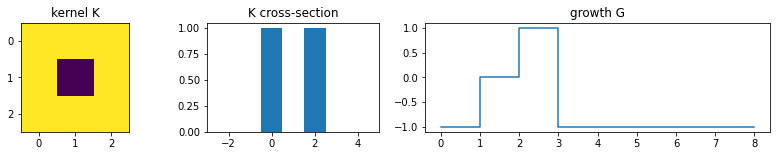

In [4]:
size = 64
np.random.seed(0)
A = np.random.randint(2, size=(size, size))
K = np.asarray([[1,1,1], [1,0,1], [1,1,1]])
K_sum = np.sum(K)
# define growth function with growth/shrink ranges
def growth(U):
  return 0 + (U==3) - ((U<2)|(U>3))
def update(i):
  global A
  U = scipy.signal.convolve2d(A, K, mode='same', boundary='wrap')
  # use incremental update and clipping
  A = np.clip(A + growth(U), 0, 1)
  img.set_array(A)
  return img,
figure_asset(K, growth, K_sum=K_sum, bar_K=True)
fig = figure_world(A, cmap='binary')
IPython.display.HTML(matplotlib.animation.FuncAnimation(fig, update, frames=50, interval=50).to_jshtml())

# Welcome to Primordia

From now on, we will try to achieve continuous states, continuous time, and continuous space, one by one.

First we allow multiple states (still discrete) instead of only 0 or 1 in GoL. The growth/shrink ranges have been adjusted. The resulting patterns become more complex.

You can change the number of states.

In [5]:
''' Primordia '''
size = 64
# multiple states
states = 12
np.random.seed(0)
A = np.random.randint(states+1, size=(size, size))
K = np.asarray([[1,1,1], [1,0,1], [1,1,1]])
K_sum = states * np.sum(K)
def growth(U):
  # adjust growth/shrink ranges
  return 0 + ((U>=20)&(U<=24)) - ((U<=18)|(U>=32))
def update(i):
  global A
  U = scipy.signal.convolve2d(A, K, mode='same', boundary='wrap')
  A = np.clip(A + growth(U), 0, states)
  # normalize pixels for image
  img.set_array(A / states)
  return img,
figure_asset(K, growth, K_sum=K_sum, bar_K=True)
fig = figure_world(A / states)
IPython.display.HTML(matplotlib.animation.FuncAnimation(fig, update, frames=200, interval=20).to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

To allow continuous states, firstly we have to normalize the neighbor sums (normalize = rescale to the range 0..1), which is equivalent to normalizing the kernel and the growth/shrink ranges. The resulting patterns don't change qualitatively.

In [6]:
size = 64
states = 12
np.random.seed(0)
A = np.random.randint(states+1, size=(size, size))
K = np.asarray([[1,1,1], [1,0,1], [1,1,1]])
K_sum = states * np.sum(K)
# normalize kernel
K = K / K_sum
def growth(U):
  # normalize growth/shrink ranges
  return 0 + ((U>=0.20)&(U<=0.25)) - ((U<=0.18)|(U>=0.33))
def update(i):
  global A
  U = scipy.signal.convolve2d(A, K, mode='same', boundary='wrap')
  A = np.clip(A + growth(U), 0, states)
  img.set_array(A / states)
  return img,
figure_asset(K, growth, bar_K=True)
fig = figure_world(A / states)
IPython.display.HTML(matplotlib.animation.FuncAnimation(fig, update, frames=200, interval=20).to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

Secondly, the states are normalized from discrete numbers to the range 0..1, thus become continuous (effectively infinite number of states, but technically it's subject to the precision of floating point numbers). The original number of states loses its meaning, and can be reframed as the number of timesteps (T). By taking T to infinity, i.e. very small timesteps, time will become continuous as well. The resulting patterns don't change qualitatively.

You can change T.

In [7]:
size = 64
# number of states no longer useful, rebranded as number of timestep
T = 12
np.random.seed(0)
# normalize states
A = np.random.rand(size, size)
K = np.asarray([[1,1,1], [1,0,1], [1,1,1]])
K = K / np.sum(K)
def growth(U):
  return 0 + ((U>=0.20)&(U<=0.25)) - ((U<=0.19)|(U>=0.33))
def update(i):
  global A
  U = scipy.signal.convolve2d(A, K, mode='same', boundary='wrap')
  A = np.clip(A + growth(U) / T, 0, 1)
  img.set_array(A)
  return img,
figure_asset(K, growth, bar_K=True)
fig = figure_world(A)
IPython.display.HTML(matplotlib.animation.FuncAnimation(fig, update, frames=200, interval=20).to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

# Welcome to Lenia

After states and time become continuous, space could become continuous as well, with the following steps.

Firstly, the convolution kernel is enlarged to radius R (i.e. extended Moore neighborhood), but is still rectangular in shape. The resulting patterns acquired a sort of fluid like quality.

You can change R.

In [8]:
size = 64
T = 12
R = 5
np.random.seed(0)
A = np.random.rand(size, size)
# larger rectangular kernel
K = np.ones((2*R+1, 2*R+1)); K[R, R] = 0
K = K / np.sum(K)
def growth(U):
  return 0 + ((U>=0.12)&(U<=0.15)) - ((U<0.12)|(U>0.15))
def update(i):
  global A
  U = scipy.signal.convolve2d(A, K, mode='same', boundary='wrap')
  A = np.clip(A + growth(U) / T, 0, 1)
  img.set_array(A)
  return img,
figure_asset(K, growth, bar_K=True)
fig = figure_world(A)
IPython.display.HTML(matplotlib.animation.FuncAnimation(fig, update, frames=200, interval=20).to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

Next, hand draw a circular kernel with the same radius. The circular kernel shape removes the orthogonal bias (i.e. the horizontal and vertical strips) in the patterns.

You can modify the kernel.

In [9]:
size = 64
T = 12
R = 5
np.random.seed(0)
A = np.random.rand(size, size)
# circular kernel
K = np.asarray([
[0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
[0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
[1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1],
[1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1],
[1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1],
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
[0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
[0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]])
K = K / np.sum(K)
def growth(U):
  # adjust growth/shrink range
  return 0 + ((U>=0.12)&(U<=0.15)) - ((U<0.12)|(U>0.15))
def update(i):
  global A, img
  U = scipy.signal.convolve2d(A, K, mode='same', boundary='wrap')
  A = np.clip(A + growth(U) / T, 0, 1)
  img.set_array(A)
  return img,
figure_asset(K, growth, bar_K=True)
fig = figure_world(A)
IPython.display.HTML(matplotlib.animation.FuncAnimation(fig, update, frames=200, interval=20).to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

The circular kernel can be replaced with a smooth function (here Gaussian function). U became weighted neighbor sums, with the kernel being the weights. The patterns became smoother (but barely observable in small world sizes).

In [10]:
bell = lambda x, m, s: np.exp(-((x-m)/s)**2 / 2)
size = 64
T = 12
R = 10
np.random.seed(0)
A = np.random.rand(size, size)
# smooth circular kernel
D = np.linalg.norm(np.asarray(np.ogrid[-R:R, -R:R]) + 1) / R
K = (D<1) * bell(D, 0.5, 0.15)
K = K / np.sum(K)
def growth(U):
  return 0 + ((U>=0.12)&(U<=0.15)) - ((U<0.12)|(U>0.15))
def update(i):
  global A, img
  U = scipy.signal.convolve2d(A, K, mode='same', boundary='wrap')
  A = np.clip(A + growth(U) / T, 0, 1)
  img.set_array(A)
  return img,
figure_asset(K, growth)
fig = figure_world(A)
IPython.display.HTML(matplotlib.animation.FuncAnimation(fig, update, frames=200, interval=20).to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

Lastly, the growth function can also be replaced by a smooth function (here Gaussian function) with parameters growth center (m) and growth width (s). The patterns became even smoother.

You can change m and s.

In [11]:
bell = lambda x, m, s: np.exp(-((x-m)/s)**2 / 2)
size = 64
scale = 2
T = 12
R = 10
np.random.seed(0)
A = np.random.rand(size, size)
D = np.linalg.norm(np.asarray(np.ogrid[-R:R, -R:R]) + 1) / R
K = (D<1) * bell(D, 0.5, 0.15)
K = K / np.sum(K)
def growth(U):
  # smooth growth function
  m = 0.135
  s = 0.015
  return bell(U, m, s)*2-1
def update(i):
  global A, img
  U = scipy.signal.convolve2d(A, K, mode='same', boundary='wrap')
  A = np.clip(A + growth(U) / T, 0, 1)
  img.set_array(A)
  return img,
figure_asset(K, growth)
fig = figure_world(A)
IPython.display.HTML(matplotlib.animation.FuncAnimation(fig, update, frames=200, interval=20).to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

For more efficient calculations, the naive convolution calculation can be replaced by using fast Fourier transform (FFT) according to the [convolution theorem](https://en.wikipedia.org/wiki/Convolution_theorem).

In [12]:
bell = lambda x, m, s: np.exp(-((x-m)/s)**2 / 2)
size = 64;  mid = size // 2
T = 12
R = 10
np.random.seed(0)
A = np.random.rand(size, size)
# to use FFT, kernel and world must have the same size
D = np.linalg.norm(np.ogrid[-mid:mid, -mid:mid]) / R
K = (D<1) * bell(D, 0.5, 0.15)
# prepare FFT of kernel
fK = np.fft.fft2(np.fft.fftshift(K / np.sum(K)))
def growth(U):
  m = 0.135
  s = 0.015
  return bell(U, m, s)*2-1
def update(i):
  global A, img
  # use FFT to do convolution
  U = np.real(np.fft.ifft2(fK * np.fft.fft2(A)))
  A = np.clip(A + growth(U) / T, 0, 1)
  img.set_array(A)
  return img,
figure_asset(K, growth)
fig = figure_world(A)
IPython.display.HTML(matplotlib.animation.FuncAnimation(fig, update, frames=200, interval=20).to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

Instead of initializing random worlds, we can load sample creatures that are stable in behavior.

The creatures are: *Orbium* (simple kernel), *Hydrogeminium* (multi-ring kernel), fish (multi-kernel), and *Tessellatium* (multi-channel).

In [13]:
#@title Define sample creatures (double click to open)
pattern = {}
pattern["orbium"] = {"name":"Orbium","R":13,"T":10,"m":0.15,"s":0.015,"b":[1],
  "cells":[[0,0,0,0,0,0,0.1,0.14,0.1,0,0,0.03,0.03,0,0,0.3,0,0,0,0],
  [0,0,0,0,0,0.08,0.24,0.3,0.3,0.18,0.14,0.15,0.16,0.15,0.09,0.2,0,0,0,0],
  [0,0,0,0,0,0.15,0.34,0.44,0.46,0.38,0.18,0.14,0.11,0.13,0.19,0.18,0.45,0,0,0],
  [0,0,0,0,0.06,0.13,0.39,0.5,0.5,0.37,0.06,0,0,0,0.02,0.16,0.68,0,0,0],
  [0,0,0,0.11,0.17,0.17,0.33,0.4,0.38,0.28,0.14,0,0,0,0,0,0.18,0.42,0,0],
  [0,0,0.09,0.18,0.13,0.06,0.08,0.26,0.32,0.32,0.27,0,0,0,0,0,0,0.82,0,0],
  [0.27,0,0.16,0.12,0,0,0,0.25,0.38,0.44,0.45,0.34,0,0,0,0,0,0.22,0.17,0],
  [0,0.07,0.2,0.02,0,0,0,0.31,0.48,0.57,0.6,0.57,0,0,0,0,0,0,0.49,0],
  [0,0.59,0.19,0,0,0,0,0.2,0.57,0.69,0.76,0.76,0.49,0,0,0,0,0,0.36,0],
  [0,0.58,0.19,0,0,0,0,0,0.67,0.83,0.9,0.92,0.87,0.12,0,0,0,0,0.22,0.07],
  [0,0,0.46,0,0,0,0,0,0.7,0.93,1,1,1,0.61,0,0,0,0,0.18,0.11],
  [0,0,0.82,0,0,0,0,0,0.47,1,1,0.98,1,0.96,0.27,0,0,0,0.19,0.1],
  [0,0,0.46,0,0,0,0,0,0.25,1,1,0.84,0.92,0.97,0.54,0.14,0.04,0.1,0.21,0.05],
  [0,0,0,0.4,0,0,0,0,0.09,0.8,1,0.82,0.8,0.85,0.63,0.31,0.18,0.19,0.2,0.01],
  [0,0,0,0.36,0.1,0,0,0,0.05,0.54,0.86,0.79,0.74,0.72,0.6,0.39,0.28,0.24,0.13,0],
  [0,0,0,0.01,0.3,0.07,0,0,0.08,0.36,0.64,0.7,0.64,0.6,0.51,0.39,0.29,0.19,0.04,0],
  [0,0,0,0,0.1,0.24,0.14,0.1,0.15,0.29,0.45,0.53,0.52,0.46,0.4,0.31,0.21,0.08,0,0],
  [0,0,0,0,0,0.08,0.21,0.21,0.22,0.29,0.36,0.39,0.37,0.33,0.26,0.18,0.09,0,0,0],
  [0,0,0,0,0,0,0.03,0.13,0.19,0.22,0.24,0.24,0.23,0.18,0.13,0.05,0,0,0,0],
  [0,0,0,0,0,0,0,0,0.02,0.06,0.08,0.09,0.07,0.05,0.01,0,0,0,0,0]]}

pattern["geminium"] = {"name":"Hydrogeminium","R":18,"T":10,"m":0.26,"s":0.036,"b":[0.5,1,0.667],
  "cells":[[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.01,0.02,0.03,0.04,0.04,0.04,0.03,0.02,0,0,0,0,0,0,0,0,0,0],
  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.04,0.1,0.16,0.2,0.23,0.25,0.24,0.21,0.18,0.14,0.1,0.07,0.03,0,0,0,0,0,0,0],
  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.01,0.09,0.2,0.33,0.44,0.52,0.56,0.58,0.55,0.51,0.44,0.37,0.3,0.23,0.16,0.08,0.01,0,0,0,0,0],
  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.13,0.29,0.45,0.6,0.75,0.85,0.9,0.91,0.88,0.82,0.74,0.64,0.55,0.46,0.36,0.25,0.12,0.03,0,0,0,0],
  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.14,0.38,0.6,0.78,0.93,1.0,1.0,1.0,1.0,1.0,1.0,0.99,0.89,0.78,0.67,0.56,0.44,0.3,0.15,0.04,0,0,0],
  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.08,0.39,0.74,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.98,0.85,0.74,0.62,0.47,0.3,0.14,0.03,0,0],
  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.32,0.76,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.88,0.75,0.61,0.45,0.27,0.11,0.01,0],
  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.35,0.83,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.88,0.73,0.57,0.38,0.19,0.05,0],
  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.99,1.0,1.0,1.0,1.0,0.99,1.0,1.0,1.0,1.0,1.0,1.0,0.85,0.67,0.47,0.27,0.11,0.01],
  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.55,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.93,0.83,0.79,0.84,0.88,0.89,0.9,0.93,0.98,1.0,1.0,1.0,1.0,0.98,0.79,0.57,0.34,0.15,0.03],
  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.47,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.9,0.72,0.54,0.44,0.48,0.6,0.7,0.76,0.82,0.91,0.99,1.0,1.0,1.0,1.0,0.91,0.67,0.41,0.19,0.05],
  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.27,0.99,1.0,1.0,1.0,1.0,0.9,0.71,0.65,0.55,0.38,0.2,0.14,0.21,0.36,0.52,0.64,0.73,0.84,0.95,1.0,1.0,1.0,1.0,1.0,0.78,0.49,0.24,0.07],
  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.14,0.63,0.96,1.0,1.0,1.0,0.84,0.17,0,0,0,0,0,0,0,0.13,0.35,0.51,0.64,0.77,0.91,0.99,1.0,1.0,1.0,1.0,0.88,0.58,0.29,0.09],
  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.07,0.38,0.72,0.95,1.0,1.0,1.0,0.22,0,0,0,0,0,0,0,0,0,0.11,0.33,0.5,0.67,0.86,0.99,1.0,1.0,1.0,1.0,0.95,0.64,0.33,0.1],
  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.32,0.49,0.71,0.93,1.0,1.0,1.0,0.56,0,0,0,0,0,0,0,0,0,0,0,0.1,0.31,0.52,0.79,0.98,1.0,1.0,1.0,1.0,0.98,0.67,0.35,0.11],
  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.01,0.6,0.83,0.98,1.0,1.0,0.68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.15,0.38,0.71,0.97,1.0,1.0,1.0,1.0,0.97,0.67,0.35,0.11],
  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.51,0.96,1.0,1.0,0.18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.09,0.34,0.68,0.95,1.0,1.0,1.0,1.0,0.91,0.61,0.32,0.1],
  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.13,0.56,0.99,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.17,0.45,0.76,0.96,1.0,1.0,1.0,1.0,0.82,0.52,0.26,0.07],
  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.33,0.7,0.94,1.0,1.0,0.44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.33,0.68,0.91,0.99,1.0,1.0,1.0,1.0,0.71,0.42,0.19,0.03],
  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.53,0.89,1.0,1.0,1.0,0.8,0.43,0.04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.47,0.86,1.0,1.0,1.0,1.0,1.0,0.95,0.58,0.32,0.12,0],
  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.77,0.99,1.0,0.97,0.58,0.41,0.33,0.18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.54,0.95,1.0,1.0,1.0,1.0,1.0,0.8,0.44,0.21,0.06,0],
  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.39,0.83,1.0,1.0,0.55,0.11,0.05,0.15,0.22,0.06,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.58,0.99,1.0,1.0,1.0,1.0,1.0,0.59,0.29,0.11,0.01,0],
  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.04,0.55,0.81,0.86,0.97,1.0,1.0,0.5,0,0,0.01,0.09,0.03,0,0,0,0,0,0,0,0,0,0,0,0,0,0.26,0.78,1.0,1.0,1.0,1.0,1.0,0.66,0.35,0.13,0.03,0,0],
  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.33,1.0,1.0,1.0,1.0,1.0,1.0,0.93,0.11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.23,0.73,0.95,1.0,1.0,1.0,1.0,1.0,0.62,0.35,0.12,0,0,0,0],
  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.51,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.72,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.56,0.25,0.09,0,0,0,0,0],
  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.12,0.38,1.0,1.0,1.0,0.66,0.08,0.55,1.0,1.0,1.0,0.03,0,0,0,0,0,0,0,0,0,0,0,0,0,0.35,1.0,1.0,1.0,1.0,1.0,1.0,0.67,0.12,0,0,0,0,0,0,0],
  [0,0,0,0,0,0,0,0,0,0,0,0,0.6,1.0,1.0,1.0,1.0,1.0,1.0,0.49,0,0,0.87,1.0,0.88,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,1.0,1.0,1.0,1.0,0.7,0.07,0,0,0,0,0,0,0,0],
  [0,0,0,0,0,0,0,0,0,0.04,0.21,0.48,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,0.04,0.42,0.26,0,0,0,0,0,0,0,0,0,0.12,0.21,0.34,0.58,1.0,1.0,1.0,0.99,0.97,0.99,0.46,0,0,0,0,0,0,0,0,0,0],
  [0,0,0,0,0,0,0,0,0,0.5,1.0,1.0,1.0,1.0,0.96,0,0.31,1.0,1.0,1.0,0.53,0,0,0,0,0,0,0,0,0.2,0.21,0,0,0,0.27,1.0,1.0,1.0,1.0,1.0,1.0,0.87,0.52,0.01,0,0,0,0,0,0,0,0,0,0,0],
  [0,0,0,0,0,0,0,0,0.84,1.0,1.0,1.0,1.0,1.0,0,0,0,0.83,1.0,1.0,0.52,0,0,0,0,0,0,0,0.26,0.82,0.59,0.02,0,0,0.46,1.0,1.0,1.0,1.0,1.0,0.9,0.55,0,0,0,0,0,0,0,0,0,0,0,0,0],
  [0,0,0,0,0,0,0,0.39,0.99,1.0,1.0,1.0,1.0,0.78,0.04,0,0,0,0.93,0.92,0,0,0,0,0,0,0,0,0.69,1.0,1.0,0.36,0,0,1.0,1.0,0.65,0.66,0.97,0.87,0.54,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
  [0,0,0,0,0.55,0.75,0.59,0.74,1.0,1.0,0,0,0.75,0.71,0.18,0,0,0,0,0,0,0,0,0,0,0.29,0,0,0.45,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.47,0.39,0.71,0.25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
  [0,0,0,0,0.69,0.81,0.8,0.92,1.0,0.13,0,0,0.13,0.94,0.58,0,0,0,0,0,0,0,0,0,1.0,1.0,0.34,0,0.04,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
  [0,0,0,0,0.63,0.85,0.9,0.98,1.0,0.09,0,0,0.02,1.0,0.64,0,0,0,0,0,0,0,0,0.59,1.0,1.0,0.84,0,0,1.0,1.0,1.0,1.0,1.0,1.0,0.64,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
  [0,0,0,0,0.64,0.65,0.67,1.0,1.0,0.21,0.01,0,0.04,0.02,0,0,0,0,0,0,0,0,0,0.69,1.0,1.0,1.0,0.29,0.37,1.0,1.0,0.6,0.63,1.0,0.84,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
  [0,0,0,0,0.44,0.73,0.73,0.85,1.0,0.97,0.23,0.05,0,0,0,0,0,0,0,0,0.06,0,0,0,0.97,1.0,1.0,1.0,1.0,1.0,1.0,0.33,0.24,0.67,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
  [0,0,0,0.12,0.55,0.9,0.9,1.0,1.0,1.0,0.43,0.04,0,0,0,0,0,0,0,0.31,0.54,0,0,0,0.88,1.0,1.0,1.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
  [0,0,0,0.29,0.71,1.0,1.0,1.0,1.0,0.79,0.28,0,0,0,0,0,0,0,0,0.4,0.77,0.54,0,0,0.87,1.0,1.0,1.0,1.0,1.0,0.31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
  [0,0.16,0.27,0.41,0.72,0.99,1.0,1.0,0.82,0.42,0.09,0,0,0,0,0,0,0,0,0.1,0.55,0.58,0.58,0.77,0.99,1.0,1.0,1.0,1.0,0.63,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
  [0.31,0.48,0.45,0.46,0.63,0.88,1.0,0.83,0.59,0.28,0.06,0,0,0,0,0,0,0,0,0,0.32,0.7,0.95,1.0,1.0,1.0,1.0,0.7,0.58,0.12,0.04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
  [0.23,0.54,0.53,0.48,0.57,0.59,0.65,0.63,0.55,0.35,0.13,0.03,0.02,0.09,0.74,1.0,0.09,0,0,0,0.32,0.86,1.0,1.0,1.0,1.0,0.57,0.44,0.31,0.16,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
  [0,0.31,0.45,0.31,0.18,0.28,0.39,0.47,0.54,0.5,0.35,0.2,0.16,0.28,0.75,1.0,0.42,0.01,0,0,0.6,1.0,1.0,1.0,1.0,0.51,0.29,0.09,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
  [0,0,0,0,0,0.14,0.3,0.4,0.54,0.71,0.74,0.65,0.49,0.35,0.27,0.47,0.6,0.6,0.72,0.98,1.0,1.0,1.0,1.0,0.65,0.33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
  [0,0,0,0,0,0.06,0.33,0.53,0.69,0.94,0.99,1.0,0.84,0.41,0.16,0.15,0.96,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.73,0.13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
  [0,0,0,0,0,0,0.42,0.86,0.98,0.98,0.99,1.0,0.94,0.63,0.32,0.62,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.65,0.23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
  [0,0,0,0,0,0.07,0.62,0.95,1.0,1.0,0.99,0.98,0.99,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.98,0.14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
  [0,0,0,0,0,0.03,0.46,0.89,1.0,1.0,0.97,0.83,0.75,0.81,0.94,1.0,1.0,1.0,1.0,0.99,0.03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
  [0,0,0,0,0,0,0.14,0.57,0.88,0.93,0.81,0.58,0.45,0.48,0.64,0.86,0.97,0.99,0.99,0.42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
  [0,0,0,0,0,0,0,0,0.23,0.45,0.47,0.39,0.29,0.19,0.2,0.46,0.28,0.03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
  [0,0,0,0,0,0,0,0,0,0,0.08,0.22,0.24,0.15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
  [0,0,0,0,0,0,0,0,0,0,0,0.07,0.22,0.14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]}

pattern["fish"] = {"name":"K=3 Fish","R":10,"T":5,"kernels":[
  {"b":[1,0.417,0.667],"m":0.156,"s":0.0118,"h":1,"c0":0,"c1":0},
  {"b":[0.083,1],"m":0.193,"s":0.049,"h":1,"c0":0,"c1":0},
  {"b":[1],"m":0.342,"s":0.0891,"h":1,"c0":0,"c1":0}],
  "cells":[[0,0,0,0,0,0,0,0,0,0,0,0.06,0.1,0.04,0.02,0.01,0,0,0,0,0,0],
  [0,0,0,0,0,0,0,0,0.15,0.37,0.5,0.44,0.19,0.23,0.3,0.23,0.15,0.01,0,0,0,0],
  [0,0,0,0,0,0,0.32,0.78,0.26,0,0.11,0.11,0.1,0.08,0.18,0.16,0.17,0.24,0.09,0,0,0],
  [0,0,0,0,0.45,0.16,0,0,0,0,0,0.15,0.15,0.16,0.15,0.1,0.09,0.21,0.24,0.12,0,0],
  [0,0,0,0.1,0,0,0,0,0,0,0,0.17,0.39,0.43,0.34,0.25,0.15,0.16,0.15,0.25,0.03,0],
  [0,0.15,0.06,0,0,0,0,0,0,0,0.24,0.72,0.92,0.85,0.61,0.47,0.39,0.27,0.12,0.18,0.17,0],
  [0,0.08,0,0,0,0,0,0,0,0,1.0,1.0,1.0,1.0,0.73,0.6,0.56,0.31,0.12,0.15,0.24,0.01],
  [0,0.16,0,0,0,0,0,0,0,0.76,1.0,1.0,1.0,1.0,0.76,0.72,0.65,0.39,0.1,0.17,0.24,0.05],
  [0,0.05,0,0,0,0,0,0,0.21,0.83,1.0,1.0,1.0,1.0,0.86,0.85,0.76,0.36,0.17,0.13,0.21,0.07],
  [0,0.05,0,0,0.02,0,0,0,0.4,0.91,1.0,1.0,1.0,1.0,1.0,0.95,0.79,0.36,0.21,0.09,0.18,0.04],
  [0.06,0.08,0,0.18,0.21,0.1,0.03,0.38,0.92,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.64,0.31,0.12,0.07,0.25,0],
  [0.05,0.12,0.27,0.4,0.34,0.42,0.93,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.97,0.33,0.16,0.05,0.1,0.26,0],
  [0,0.25,0.21,0.39,0.99,1.0,1.0,1.0,1.0,1.0,1.0,0.86,0.89,0.94,0.83,0.13,0,0,0.04,0.21,0.18,0],
  [0,0.06,0.29,0.63,0.84,0.97,1.0,1.0,1.0,0.96,0.46,0.33,0.36,0,0,0,0,0,0.03,0.35,0,0],
  [0,0,0.13,0.22,0.59,0.85,0.99,1.0,0.98,0.25,0,0,0,0,0,0,0,0,0.34,0.14,0,0],
  [0,0,0,0,0.33,0.7,0.95,0.8,0.33,0.11,0,0,0,0,0,0,0,0.11,0.26,0,0,0],
  [0,0,0,0,0.16,0.56,0.52,0.51,0.4,0.18,0.01,0,0,0,0,0,0,0.42,0,0,0,0],
  [0,0,0,0,0.01,0,0.33,0.47,0.33,0.05,0,0,0,0,0,0,0.35,0,0,0,0,0],
  [0,0,0,0,0,0.26,0.32,0.13,0,0,0,0,0,0,0,0.34,0,0,0,0,0,0],
  [0,0,0,0,0,0.22,0.25,0.03,0,0,0,0,0,0,0.46,0,0,0,0,0,0,0],
  [0,0,0,0,0,0,0.09,0.2,0.22,0.23,0.23,0.22,0.3,0.3,0,0,0,0,0,0,0,0]]}

pattern["aquarium"] = {"name":"Tessellatium gyrans","R":12,"T":1,"kernels":[
  {"b":[1],"m":0.272,"s":0.0595,"h":0.19,"r":0.91,"c0":0,"c1":0},
  {"b":[1],"m":0.349,"s":0.1585,"h":0.66,"r":0.62,"c0":0,"c1":0},
  {"b":[1,0.25],"m":0.2,"s":0.0332,"h":0.39,"r":0.5,"c0":0,"c1":0},
  {"b":[0,1],"m":0.114,"s":0.0528,"h":0.38,"r":0.97,"c0":1,"c1":1},
  {"b":[1],"m":0.447,"s":0.0777,"h":0.74,"r":0.72,"c0":1,"c1":1},
  {"b":[0.833,1],"m":0.247,"s":0.0342,"h":0.92,"r":0.8,"c0":1,"c1":1},
  {"b":[1],"m":0.21,"s":0.0617,"h":0.59,"r":0.96,"c0":2,"c1":2},
  {"b":[1],"m":0.462,"s":0.1192,"h":0.37,"r":0.56,"c0":2,"c1":2},
  {"b":[1],"m":0.446,"s":0.1793,"h":0.94,"r":0.78,"c0":2,"c1":2},
  {"b":[0.917,1],"m":0.327,"s":0.1408,"h":0.51,"r":0.79,"c0":0,"c1":1},
  {"b":[0.75,1],"m":0.476,"s":0.0995,"h":0.77,"r":0.5,"c0":0,"c1":2},
  {"b":[0.917,1],"m":0.379,"s":0.0697,"h":0.92,"r":0.72,"c0":1,"c1":0},
  {"b":[1],"m":0.262,"s":0.0877,"h":0.71,"r":0.68,"c0":1,"c1":2},
  {"b":[0.167,1,0],"m":0.412,"s":0.1101,"h":0.59,"r":0.82,"c0":2,"c1":0},
  {"b":[1],"m":0.201,"s":0.0786,"h":0.41,"r":0.82,"c0":2,"c1":1}],
  "cells":[[[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.04,0,0,0,0,0,0,0,0,0],
  [0,0,0,0,0,0,0,0,0,0.49,1.0,0,0.03,0.49,0.49,0.28,0.16,0.03,0,0,0,0,0,0],
  [0,0,0,0,0,0,0,0,0,0,0,0.6,0.47,0.31,0.58,0.51,0.35,0.28,0.22,0,0,0,0,0],
  [0,0,0,0,0,0,0.15,0.32,0.17,0.61,0.97,0.29,0.67,0.59,0.88,1.0,0.92,0.8,0.61,0.42,0.19,0,0,0],
  [0,0,0,0,0,0,0,0.25,0.64,0.26,0.92,0.04,0.24,0.97,1.0,1.0,1.0,1.0,0.97,0.71,0.33,0.12,0,0],
  [0,0,0,0,0,0,0,0.38,0.84,0.99,0.78,0.67,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.95,0.62,0.37,0,0],
  [0,0,0,0,0.04,0.11,0,0.69,0.75,0.75,0.91,1.0,1.0,0.89,1.0,1.0,1.0,1.0,1.0,1.0,0.81,0.42,0.07,0],
  [0,0,0,0,0.44,0.63,0.04,0,0,0,0.11,0.14,0,0.05,0.64,1.0,1.0,1.0,1.0,1.0,0.92,0.56,0.23,0],
  [0,0,0,0,0.11,0.36,0.35,0.2,0,0,0,0,0,0,0.63,1.0,1.0,1.0,1.0,1.0,0.96,0.49,0.26,0],
  [0,0,0,0,0,0.4,0.37,0.18,0,0,0,0,0,0.04,0.41,0.52,0.67,0.82,1.0,1.0,0.91,0.4,0.23,0],
  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.04,0,0.05,0.45,0.89,1.0,0.66,0.35,0.09,0],
  [0,0,0.22,0,0,0,0.05,0.36,0.6,0.13,0.02,0.04,0.24,0.34,0.1,0,0.04,0.62,1.0,1.0,0.44,0.25,0,0],
  [0,0,0,0.43,0.53,0.58,0.78,0.9,0.96,1.0,1.0,1.0,1.0,0.71,0.46,0.51,0.81,1.0,1.0,0.93,0.19,0.06,0,0],
  [0,0,0,0,0.23,0.26,0.37,0.51,0.71,0.89,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.42,0.06,0,0,0],
  [0,0,0,0,0.03,0,0,0.11,0.35,0.62,0.81,0.93,1.0,1.0,1.0,1.0,1.0,0.64,0.15,0,0,0,0,0],
  [0,0,0,0,0,0,0.06,0.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
  [0,0,0,0,0,0,0,0.05,0.09,0.05,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]],
  [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.02,0.28,0.42,0.44,0.34,0.18,0,0,0],
  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.34,1.0,1.0,1.0,1.0,1.0,0.91,0.52,0.14,0],
  [0,0,0,0,0,0,0,0,0,0,0,0,0.01,0.17,0.75,1.0,1.0,1.0,1.0,1.0,1.0,0.93,0.35,0],
  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.22,0.92,1.0,1.0,1.0,1.0,1.0,1.0,0.59,0.09],
  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.75,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.71,0.16],
  [0,0,0,0,0,0,0,0,0,0,0,0,0.01,0.67,0.83,0.85,1.0,1.0,1.0,1.0,1.0,1.0,0.68,0.17],
  [0,0,0,0,0,0,0,0,0,0,0,0,0.21,0.04,0.12,0.58,0.95,1.0,1.0,1.0,1.0,1.0,0.57,0.13],
  [0,0,0,0,0,0,0,0,0,0,0,0.07,0,0,0,0.2,0.64,0.96,1.0,1.0,1.0,0.9,0.24,0.01],
  [0,0,0,0,0,0,0,0,0,0,0.13,0.29,0,0,0,0.25,0.9,1.0,1.0,1.0,1.0,0.45,0.05,0],
  [0,0,0,0,0,0,0,0,0,0,0.13,0.31,0.07,0,0.46,0.96,1.0,1.0,1.0,1.0,0.51,0.12,0,0],
  [0,0,0,0,0,0,0,0,0.26,0.82,1.0,0.95,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.3,0.05,0,0,0],
  [0,0,0,0,0,0,0,0,0.28,0.74,1.0,0.95,0.87,1.0,1.0,1.0,1.0,1.0,0,0,0,0,0,0],
  [0,0,0,0,0,0,0,0,0.07,0.69,1.0,1.0,1.0,1.0,1.0,0.96,0.25,0,0,0,0,0,0,0],
  [0,0,0,0,0,0,0,0,0,0,0.4,0.72,0.9,0.83,0.7,0.56,0.43,0.14,0,0,0,0,0,0],
  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]],
  [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
  [0,0,0,0,0,0,0,0,0,0,0,0,0.04,0.25,0.37,0.44,0.37,0.24,0.11,0.04,0,0,0,0],
  [0,0,0,0,0,0,0,0,0,0.19,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.75,0.4,0.15,0,0,0,0],
  [0,0,0,0,0,0,0,0,0.14,0.48,0.83,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.4,0,0,0,0],
  [0,0,0,0,0,0,0,0,0.62,0.78,0.94,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.64,0,0,0,0],
  [0,0,0,0,0,0,0,0.02,0.65,0.98,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.78,0,0,0,0],
  [0,0,0,0,0,0,0,0.15,0.48,0.93,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.79,0.05,0,0,0],
  [0,0,0,0,0,0,0.33,0.56,0.8,1.0,1.0,1.0,0.37,0.6,0.94,1.0,1.0,1.0,1.0,0.68,0.05,0,0,0],
  [0,0,0,0,0.35,0.51,0.76,0.89,1.0,1.0,0.72,0.15,0,0.29,0.57,0.69,0.86,1.0,0.92,0.49,0,0,0,0],
  [0,0,0,0,0,0.38,0.86,1.0,1.0,0.96,0.31,0,0,0,0,0.02,0.2,0.52,0.37,0.11,0,0,0,0],
  [0,0,0.01,0,0,0.07,0.75,1.0,1.0,1.0,0.48,0.03,0,0,0,0,0,0.18,0.07,0,0,0,0,0],
  [0,0.11,0.09,0.22,0.15,0.32,0.71,0.94,1.0,1.0,0.97,0.54,0.12,0.02,0,0,0,0,0,0,0,0,0,0],
  [0.06,0.33,0.47,0.51,0.58,0.77,0.95,1.0,1.0,1.0,1.0,0.62,0.12,0,0,0,0,0,0,0,0,0,0,0],
  [0.04,0.4,0.69,0.88,0.95,1.0,1.0,1.0,1.0,1.0,0.93,0.68,0.22,0.02,0,0,0.01,0,0,0,0,0,0,0],
  [0,0.39,0.69,0.91,1.0,1.0,1.0,1.0,1.0,0.85,0.52,0.35,0.24,0.17,0.07,0,0,0,0,0,0,0,0,0],
  [0,0,0.29,0.82,1.0,1.0,1.0,1.0,1.0,1.0,0.67,0.29,0.02,0,0,0,0,0,0,0,0,0,0,0],
  [0,0,0,0,0.2,0.51,0.77,0.96,0.93,0.71,0.4,0.16,0,0,0,0,0,0,0,0,0,0,0,0],
  [0,0,0,0,0,0,0,0,0.08,0.07,0.03,0,0,0,0,0,0,0,0,0,0,0,0,0]]]}

Load the sample creature *Orbium*.

You can change its scaling factor and its initial position (cx, cy).

In [14]:
bell = lambda x, m, s: np.exp(-((x-m)/s)**2 / 2)
size = 64;  mid = size // 2;  scale = 1;  cx, cy = 20, 20
# load pattern, with parameters R, T, m, s, b, and cells
globals().update(pattern["orbium"]);  b = np.array(b);  C = np.array(cells)
# place scaled pattern
A = np.zeros([size, size])
C = scipy.ndimage.zoom(C, scale, order=0);  R *= scale
A[cx:cx+C.shape[0], cy:cy+C.shape[1]] = C
D = np.linalg.norm(np.ogrid[-mid:mid, -mid:mid]) / R
K = (D<1) * bell(D, 0.5, 0.15)
fK = np.fft.fft2(np.fft.fftshift(K / np.sum(K)))
def growth(U):
  return bell(U, m, s)*2-1
def update(i):
  global A, img
  U = np.real(np.fft.ifft2(fK * np.fft.fft2(A)))
  A = np.clip(A + growth(U) / T, 0, 1)
  img.set_array(A)
  return img,
figure_asset(K, growth)
fig = figure_world(A)
IPython.display.HTML(matplotlib.animation.FuncAnimation(fig, update, frames=200, interval=20).to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

Allow multi-ring kernel with parameter b.

Load the sample creature *Hydrogeminium*.


In [15]:
bell = lambda x, m, s: np.exp(-((x-m)/s)**2 / 2)
size = 64;  mid = size // 2;  scale = 0.75;  cx, cy = 10, 10
globals().update(pattern["geminium"]);  b = np.array(b);  C = np.array(cells)
A = np.zeros([size, size])
C = scipy.ndimage.zoom(C, scale, order=0);  R *= scale
A[cx:cx+C.shape[0], cy:cy+C.shape[1]] = C
# multi-ring kernel
D = np.linalg.norm(np.ogrid[-mid:mid, -mid:mid]) / R * len(b)
K = (D<len(b)) * b[np.minimum(D.astype(int),len(b)-1)] * bell(D % 1, 0.5, 0.15)
fK = np.fft.fft2(np.fft.fftshift(K / np.sum(K)))
def growth(U):
  return bell(U, m, s)*2-1
def update(i):
  global A, img
  U = np.real(np.fft.ifft2(fK * np.fft.fft2(A)))
  A = np.clip(A + growth(U) / T, 0, 1)
  img.set_array(A)
  return img,
figure_asset(K, growth)
fig = figure_world(A)
IPython.display.HTML(matplotlib.animation.FuncAnimation(fig, update, frames=200, interval=20).to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

# Welcome to Extended Lenia

The Lenia model can be extended through various enhancements.

Here multiple kernels and multiple growth functions are allowed. Kernels (K), weighted neighbor sum (U), and resulting growth (G) became lists. A fish-like creature is loaded.

In [16]:
bell = lambda x, m, s: np.exp(-((x-m)/s)**2 / 2)
size = 64;  mid = size // 2;  scale = 1;  cx, cy = 20, 20
globals().update(pattern["fish"]);  C = np.array(cells)
A = np.zeros([size, size])
C = scipy.ndimage.zoom(C, scale, order=0);  R *= scale
A[cx:cx+C.shape[0], cy:cy+C.shape[1]] = C
# prepare multiple kernels
Ds = [ np.linalg.norm(np.ogrid[-mid:mid, -mid:mid]) / R * len(k['b']) for k in kernels ]
Ks = [ (D<len(k['b'])) * np.array(k['b'])[np.minimum(D.astype(int),len(k['b'])-1)] * bell(D%1, 0.5, 0.15) for D,k in zip(Ds,kernels) ]
nKs = [ K / np.sum(K) for K in Ks ]
fKs = [ np.fft.fft2(np.fft.fftshift(K)) for K in nKs ]
def growth(U, m, s):
  return bell(U, m, s)*2-1
def update(i):
  global A, img
  # use multiple kernerls
  Us = [ np.real(np.fft.ifft2(fK * np.fft.fft2(A))) for fK in fKs ]
  Gs = [ growth(U, k['m'], k['s']) for U,k in zip(Us,kernels) ]
  A = np.clip(A + np.mean(np.array(Gs),axis=0) / T, 0, 1)
  img.set_array(A)
  return img,
figure_asset_list(Ks, nKs, growth, kernels)
fig = figure_world(A)
IPython.display.HTML(matplotlib.animation.FuncAnimation(fig, update, frames=200, interval=20).to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

Moreover, the world can become multi-channel (shown in RGB colors). Introduce two more parameters: relative kernel radius (r) and growth height (h) for more flexibility. The multi-channel creature *Tessellatium* is loaded.

In [17]:
bell = lambda x, m, s: np.exp(-((x-m)/s)**2 / 2)
size = 128;  mid = size // 2;  scale = 2.5;  cx, cy = 20, 20
globals().update(pattern["aquarium"])
# place pattern into multiple channels
As = [ np.zeros([size, size]) for i in range(3) ]
Cs = [ scipy.ndimage.zoom(np.array(c), scale, order=0) for c in cells ];  R *= scale
for A,C in zip(As,Cs):  A[cx:cx+C.shape[0], cy:cy+C.shape[1]] = C
Ds = [ np.linalg.norm(np.ogrid[-mid:mid, -mid:mid]) / R * len(k['b']) / k['r'] for k in kernels ]
Ks = [ (D<len(k['b'])) * np.array(k['b'])[np.minimum(D.astype(int),len(k['b'])-1)] * bell(D%1, 0.5, 0.15) for D,k in zip(Ds,kernels) ]
nKs = [ K / np.sum(K) for K in Ks ]
fKs = [ np.fft.fft2(np.fft.fftshift(K)) for K in nKs ]
def growth(U, m, s):
  return bell(U, m, s)*2-1
def update(i):
  global As, img
  fAs = [ np.fft.fft2(A) for A in As ]
  # calc convolution from source channels
  Us = [ np.real(np.fft.ifft2(fK * fAs[k['c0']])) for fK,k in zip(fKs,kernels) ]
  Gs = [ growth(U, k['m'], k['s']) for U,k in zip(Us,kernels) ]
  Hs = [ sum(k['h']*G for G,k in zip(Gs,kernels) if k['c1']==c1) for c1 in range(3) ]
  hs = [ sum(k['h'] for k in kernels if k['c1']==c1) for c1 in range(3) ]
  # add growth to destination channels
  As = [ np.clip(A + H / h / T, 0, 1) for A,H,h in zip(As,Hs,hs) ]
  # show image in RGB
  img.set_array(np.dstack(As))
  return img,
figure_asset_list(Ks, nKs, growth, kernels)
fig = figure_world(np.dstack(As))
IPython.display.HTML(matplotlib.animation.FuncAnimation(fig, update, frames=200, interval=20).to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

For better visualization, the creature is placed in a larger world, displayed in four panels: world (A), weighted neighbor sums (U), resulting growths (H), kernels (K).

In [18]:
bell = lambda x, m, s: np.exp(-((x-m)/s)**2 / 2)
size = 256;  mid = size // 2;  scale = 5;  cx, cy = 80, 80
globals().update(pattern["aquarium"])
As = [ np.zeros([size, size]) for i in range(3) ]
Cs = [ scipy.ndimage.zoom(np.array(c), scale, order=0) for c in cells ];  R *= scale
for A,C in zip(As,Cs):  A[cx:cx+C.shape[0], cy:cy+C.shape[1]] = C
Ds = [ np.linalg.norm(np.ogrid[-mid:mid, -mid:mid]) / R * len(k['b']) / k['r'] for k in kernels ]
Ks = [ (D<len(k['b'])) * np.array(k['b'])[np.minimum(D.astype(int),len(k['b'])-1)] * bell(D%1, 0.5, 0.15) for D,k in zip(Ds,kernels) ]
nKs = [ K / np.sum(K) for K in Ks ]
fKs = [ np.fft.fft2(np.fft.fftshift(K)) for K in nKs ]
def growth(U, m, s):
  return bell(U, m, s)*2-1
def update(i):
  global As, img
  fAs = [ np.fft.fft2(A) for A in As ]
  Us = [ np.real(np.fft.ifft2(fK * fAs[k['c0']])) for fK,k in zip(fKs,kernels) ]
  Gs = [ growth(U, k['m'], k['s']) for U,k in zip(Us,kernels) ]
  Hs = [ sum(k['h']*G for G,k in zip(Gs,kernels) if k['c1']==c1) for c1 in range(3) ]
  hs = [ sum(k['h'] for k in kernels if k['c1']==c1) for c1 in range(3) ]
  As = [ np.clip(A + H / h / T, 0, 1) for A,H,h in zip(As,Hs,hs) ]
  U_stack = [ np.clip(np.zeros(Us[0].shape) + sum(U/2 for k,U in zip(kernels,Us) if k['c0']==l), 0, 1) for l in range(3) ]
  H_stack = [ np.clip(H + 1, 0, 1) for H in Hs ]
  # update grid
  img1.set_array(np.dstack(As))
  img2.set_array(np.dstack(U_stack))
  img3.set_array(np.dstack(H_stack))
  return img,
fig = figure_grid(As, Ks)
IPython.display.HTML(matplotlib.animation.FuncAnimation(fig, update, frames=100, interval=20).to_jshtml())


Output hidden; open in https://colab.research.google.com to view.

~ To be continued? ~